# Main Procedure


This is to explan why using two different part of test data in the multi-step pu learning is better.  
Procedure:
1. Train K OCC on training data with K types of inliers seperately, apply these K OCC to part1 test data and get K groups of predicted outliers
2. Claim the intersection of those K groups of outliers as reliable outliers(negatives)
3. Train binary Classifier on training data and reliable outliers, get scores for calibration data and part2 test data
4. Apply MAMCOD conformal procedure to get conformal pvalues
5. Apply BH procedure to get FDR and Power

Why Multi-Step PUL using two parts of test data is better:  


### Setup

In [6]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import copy

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores, prepare_pu_score_matrices
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

In [11]:
np.random.seed(100)
# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 8

# Training data
n_in_train = [100, 100]

# Calibration data (Here callibrariton data has no effect if not using conformal inference)
n_in_cal = [1000, 1000]

# Test data (Unlabeled Data)
n_in_test = [900, 900]
n_out_test = 200
n_test = sum(n_in_test) + n_out_test

# Data Generation
X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
X_test_part2, Y_test_part2 = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)

### Compute the MAMCOD p-values Using PU Learning

In [12]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

# Compute conformity scores
scores_cal_multi_step, scores_test_multi_step,_ = compute_pu_scores(
    K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
    oneclass_classifier= oneclass_classifier, multi_step=True)
scores_cal_twotest, scores_test_twotest,_  = compute_pu_scores(
    K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
    oneclass_classifier = oneclass_classifier, multi_step = True, X_test_part2 = X_test_part2)

scores_cal_mat, scores_test_mat = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal, scores_test)
scores_cal_mat_part2, scores_test_mat_part2 = prepare_pu_score_matrices(K, n_in_cal, n_test, scores_cal_part2, scores_test_part2)

# Compute MAMCOD conformal p-values
MAMCOD_pv = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat, scores_test_mat, is_high_score_inlier = False)
MAMCOD_pv_part2 = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_part2, scores_test_mat_part2, is_high_score_inlier = False)

### Compute FDR and Power by BH procedure

In [13]:
fdr, power = compute_fdr_power(MAMCOD_pv, Y_test, alpha = 0.1)
fdr_part2, power_part2 = compute_fdr_power(MAMCOD_pv_part2, Y_test_part2, alpha = 0.1)

print("FDR:", fdr)
print("Power:", power)
print("FDR_part2:", fdr_part2)
print("Power_part2:", power_part2)

FDR: 0.07834101382488479
Power: 1.0
FDR_part2: 0.1111111111111111
Power_part2: 1.0


### Plot

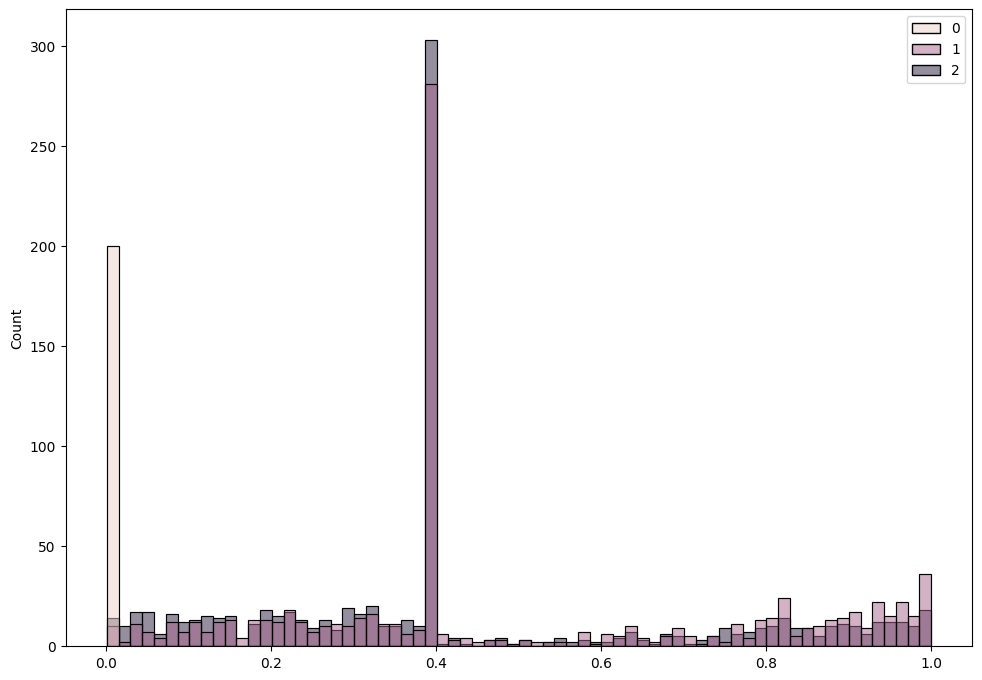

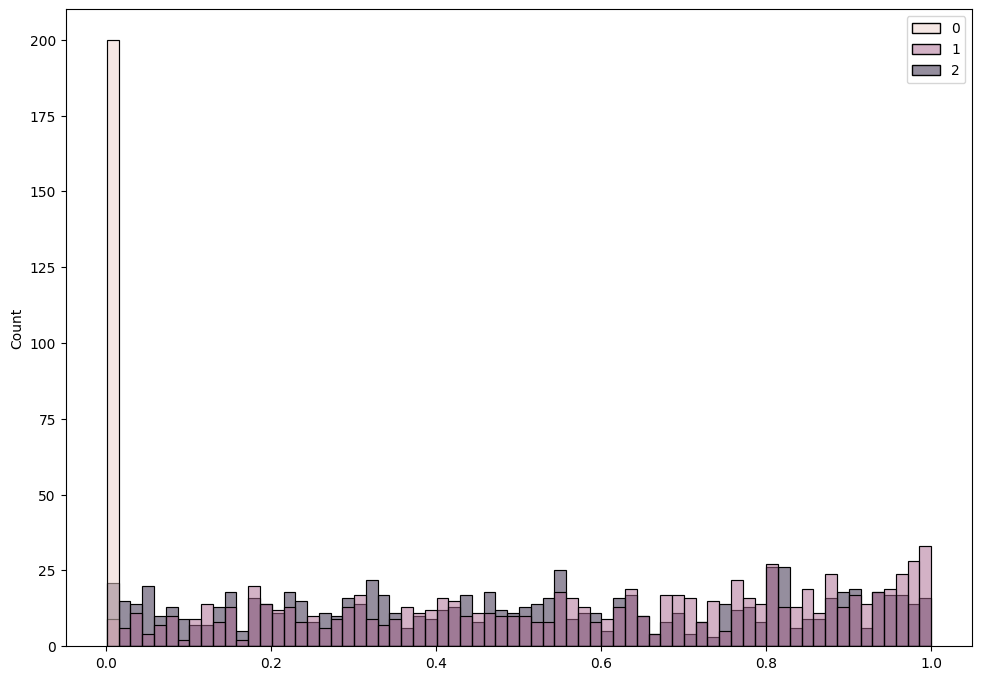

In [14]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27

sns.histplot(x=MAMCOD_pv, hue=Y_test, bins=70)
plt.show()

sns.histplot(x=MAMCOD_pv_part2, hue=Y_test_part2, bins=70)
plt.show()